Load the model, do the prediction on validation dataset, compare the original masks and infer what kind of images are failing

In [39]:
# Import the required packages
from keras.models import load_model
from utils import mean_iou
import os
from tqdm import tqdm_notebook, tnrange
from keras.preprocessing.image import img_to_array, load_img
from matplotlib import pyplot as plt
from skimage.transform import resize
import numpy as np
import random

In [2]:
# Load model
model = load_model('model-tgs-salt-1.h5', custom_objects = {'mean_iou': mean_iou})

In [4]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = '/datasets/kaggle/competitions/tgs-salt-identification-challenge/train/'
path_test = '/datasets/kaggle/competitions/tgs-salt-identification-challenge/test/'

In [11]:
# Get train ids
train_ids = next(os.walk(path_train + "images"))[2]

In [25]:
X_train = np.zeros((len(train_ids), im_width, im_height, im_chan), dtype=np.uint8)
print(X_train.shape)

(4000, 128, 128, 1)


In [28]:
# Get and resize the train images
sizes_train = []
for i, _id in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = load_img(path_train + 'images/{}'.format(_id))
    t = img_to_array(img)[:,:,1]
    sizes_train.append([t.shape[0], t.shape[1]])
    t = resize(t, (128, 128, 1),mode='constant', preserve_range=True)
    X_train[i] = t

In [27]:
predicts_train = model.predict(X_train, verbose=1)

4000/4000 [==============================] - 29s 7ms/step


In [55]:
def upsample(predicts_train):
    preds_train_upsampled = []
    for i in tnrange(len(predicts_train)):
        preds_train_upsampled.append(resize(np.squeeze(predicts_train[i]), 
                                           (sizes_train[i][0], sizes_train[i][1]), 
                                           mode='constant', preserve_range=True))
    return preds_train_upsampled

In [56]:
# Create list of upsampled train masks
predicts_train_upsampled = upsample(predicts_train)

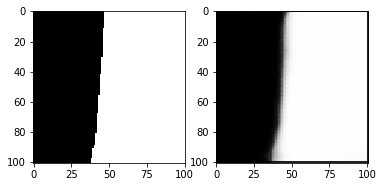

In [36]:
m1 = load_img(path_train + 'masks/{}'.format(train_ids[1]))
plt.subplot(1,2,1)
plt.imshow(m1)
plt.subplot(1, 2, 2)
plt.imshow(np.dstack((preds_train_upsampled[1],preds_train_upsampled[1], preds_train_upsampled[1])))
plt.show()

In [47]:
def get_random_idxs(num_of_imgs, pred):
    random_idxs = []
    for i in range(num_of_imgs):
        random_idxs.append(random.randint(0, len(pred)))
    return random_idxs

In [48]:
def plot_imgs_for_comparison(random_idxs, train_ids, pred):
    fig_num = 1;
    num_of_imgs = len(random_idxs)
    for _id in random_idxs:
        print(train_ids[_id])
        m1 = load_img(path_train + 'masks/{}'.format(train_ids[_id]))
        plt.subplot(num_of_imgs,2,fig_num)
        fig_num = fig_num + 1;
        plt.imshow(m1)
        plt.subplot(num_of_imgs, 2, fig_num)
        fig_num = fig_num + 1;
        plt.imshow(np.dstack((pred[_id],pred[_id], pred[_id])))
        plt.show()

In [77]:
random_idxs = get_random_idxs(4, preds_train_upsampled)

6cf6889e33.png


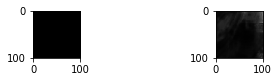

6d9b6a2c4b.png


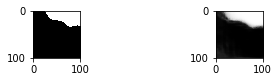

5423d6049c.png


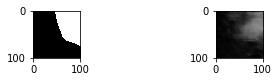

cbe33c57c4.png


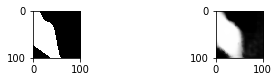

In [78]:
# plot the prediction masks and ground truth masks
plot_imgs_for_comparison(random_idxs, train_ids, preds_train_upsampled)

In [ ]:
predicts_train_t = predicts_train.copy()
from scipy import ndimage
# predicts_train_t = ndimage.generic_filter(predicts_train_t, np.nanmean, size=3, mode='constant', cval=np.NaN)
predicts_train_t[predicts_train_t > 0] = 255
# preds_train_t = (predicts_train > 0.5).astype(np.uint8)
preds_train_upsampled_t = upsample(preds_train_t)

6cf6889e33.png


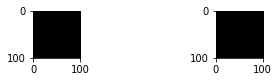

6d9b6a2c4b.png


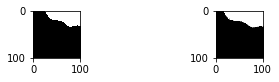

5423d6049c.png


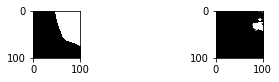

cbe33c57c4.png


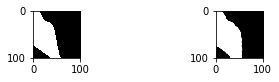

In [80]:
# plot the thresholded prediction masks and ground truth masks
plot_imgs_for_comparison(random_idxs, train_ids, preds_train_upsampled_t)